# TEgenomeSimulator Reliability Analysis

## What is a reliability analysis?

This tutorial will cover the application of a simple reliability analysis on TEgenomeSimulator. The purpose of which is to demonstrate how one can apply calibration procedures to analyse and refine individual mechanistic processes within a simulation model.

The primary aim of a reliability analysis is to compute the probability of any event under uncertainty defined by a threshold or condition:

$$
E = \{ \mathbf{X} \mid g(\mathbf{X}) \le 0 \}
$$

**Examples**

- **Exceeding a threshold:**  
  $g(X) = X_1 + X_2 - 5 → P(X_1 + X_2 > 5)$

- **Inside a safe zone:**  
  $g(X) = X_1^2 + X_2^2 - 1 → P(X_1^2 + X_2^2 \le 1)$

- **Any custom condition:**  
  Define $g(X)$ however you like. calisim just finds the probability that $g(X) \le 0$.

Secondary purposes include:

- **Sensitivity analysis:**  
  Find which inputs most influence reliability (via FORM importance factors).

- **Design optimization:**  
  Adjust parameters to meet a target failure probability.

- **Risk assessment:**  
  Handle multiple failure modes or safety thresholds.

- **Efficient simulation:**  
  Use FORM, importance sampling, or subset simulation  
  to focus on rare or critical events.

# Imports

We will first import all required dependencies and specify our constants.

In [2]:
import pandas as pd
import numpy as np
import os.path as osp
from subprocess import Popen
import subprocess
from pathlib import Path
import shutil

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.reliability import (
	ReliabilityAnalysisMethod,
	ReliabilityAnalysisMethodModel,
)

M = 0
c = str(Path("data", "random_genome_chr_index.csv"))
r = str(Path("data", "combined_curated_TE_lib_ATOSZM_selected.fasta"))
o="data"
m = 2
n = 2
seed = 100

# Calibration procedure

## Reliability Analysis

We will next run the reliability analysis. For this exercise, there are four parameters of interest within TEgenomeSimulator: 

- **maxidn**: The upper bound of mean sequence identity to be sampled for each TE family (default is 95; i.e. 95 percent).
- **minidn**: The lower bound of mean sequence identity to be sampled for each TE family (default is 80; i.e. 80 percent).
- **maxsd**:  The upper bound of standard deviation of mean identity to be sampled for each TE family (default is 20).
- **minsd**: The lower bound of standard deviation of mean identity to be sampled for each TE family (default is 1).

The mean sequence identity for each TE family will be sampled from a Normal distribution as specified by these four parameters. Let's use a reliability analysis to evaluate how these four parameters impact the mean sequence identities sampled for each TE family.

We will first specify our parameter distributions:

In [6]:
parameter_spec = ParameterSpecification(
    parameters=[
        DistributionModel(
            name="maxidn",
            distribution_name="uniform",
            distribution_args=[90, 95],
            data_type=ParameterDataType.DISCRETE,
        ),
        DistributionModel(
            name="minidn",
            distribution_name="uniform",
            distribution_args=[75, 85],
            data_type=ParameterDataType.DISCRETE,
        ),
        DistributionModel(
            name="maxsd",
            distribution_name="uniform",
            distribution_args=[15, 25],
            data_type=ParameterDataType.DISCRETE,
        ),
        DistributionModel(
            name="minsd",
            distribution_name="uniform",
            distribution_args=[1, 3],
            data_type=ParameterDataType.DISCRETE,
        )
    ]
)

We will next define our reliability analysis function. We will run TEgenomeSimulator in mode 0, and subsequently extract the distribution of sampled mean sequence identities for each TE families. We'll take the average of the distribution of sampled identities across all TE families.

In [10]:
def reliability_func(
    parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    maxidn = parameters["maxidn"]
    minidn = parameters["minidn"]
    maxsd = parameters["maxsd"]
    minsd = parameters["minsd"]

    p = simulation_id

    cmd = f"tegenomesimulator -M {M} -p {p} -c {c} -r {r} -o {o} -m {m} -n {n} --maxidn {maxidn} --minidn {minidn} --maxsd {maxsd} --minsd {minsd} -s {seed}"
    Popen(cmd, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL).wait()

    repeat_annotation_path = f"{o}/TEgenomeSimulator_{p}_result/{p}_repeat_annotation_out_final.gff"
    df = pd.read_csv(repeat_annotation_path, sep="\t", header=None)
    shutil.rmtree(f"{o}/TEgenomeSimulator_{p}_result")

    mean_identity = df.iloc[:, 8].str.split(";").str[3].str.replace("Identity=", "").astype("float").mean()
    return mean_identity

We will next run the reliability analysis using the Sobol method. Of our many TEgenomeSimulator runs, what is the probability that the average of the sequence identities across all TE families will be greater than or equal to 82.5%?

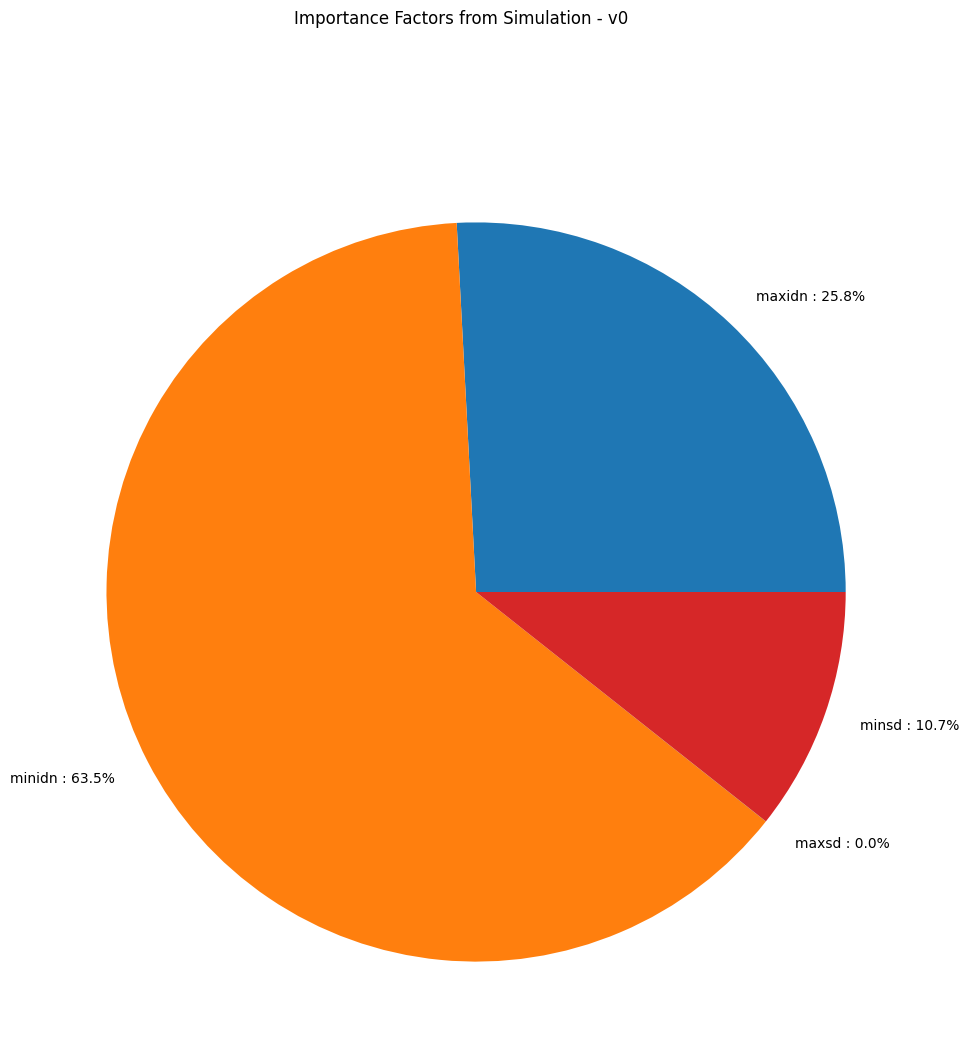

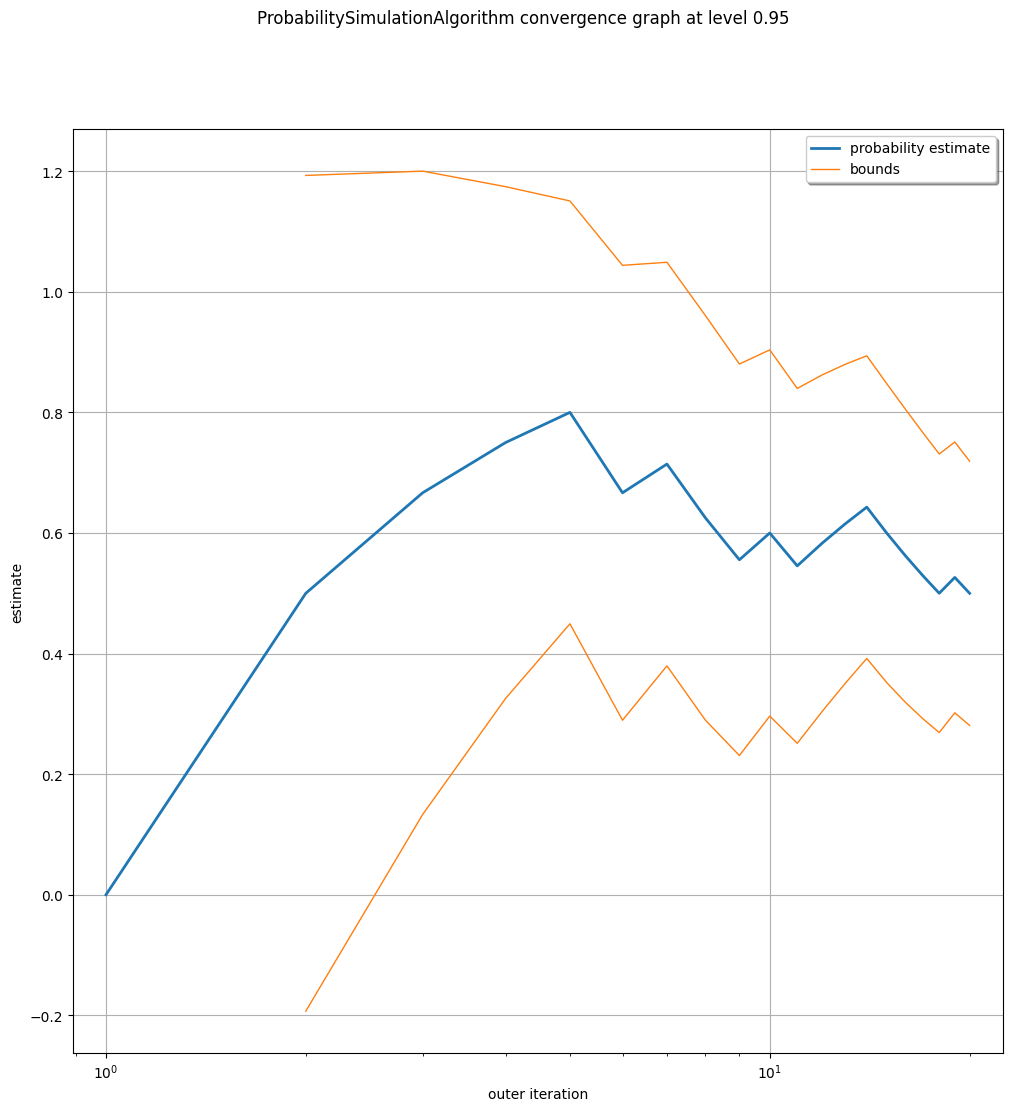

In [11]:
specification = ReliabilityAnalysisMethodModel(
    experiment_name="openturns_reliability_analysis",
    parameter_spec=parameter_spec,
    method="sobol",
	n_samples=20,
	comparison="greater_or_equal",
	threshold=0.825,
    output_labels=["Mean Sequence Identities"],
)

calibrator = ReliabilityAnalysisMethod(
    calibration_func=reliability_func, specification=specification, engine="openturns"
)

calibrator.specify().execute().analyze()

In [13]:
calibrator.implementation.sampler.getResult()

probabilityEstimate=5.000000e-01 varianceEstimate=1.250000e-02 standard deviation=1.12e-01 coefficient of variation=2.24e-01 confidenceLength(0.95)=4.38e-01 outerSampling=20 blockSize=1

According to these results, he lower bound of mean sequence identity to be sampled for each TE family is most influential in determining whether the probability that the average of the sequence identities across all TE families will be greater than or equal to 82.5%.

Noting that our results are stochastic (and that the number of samples is fairly small), according to these results there is a 50% probability that the average of the sequence identities across all TE families will be greater than or equal to 82.5%.

It's worth mentioning that the mean sequence identities are not actually normally distributed in reality. TEgenomeSimulator applies a post-hoc fix that upwardly biases the sampled identities:

$$
\text{identity\_fix} = \text{identity} + (100 - \text{identity}) \cdot 0.5
$$

A future exercise for the interested reader would be to evaluate how the four TEgenomeSimulator parameters above impact the upwardly biased sampled identities through the use of a reliability analysis. This would give us a better idea of how influential this post-hoc fix is in determining the distribution of our sampled identities.